[*********************100%***********************]  1 of 1 completed


Cleaned Time Series Data: Date
2010-01-04     15.684434
2010-01-05     15.615365
2010-01-06     15.221722
2010-01-07     14.867367
2010-01-08     15.065566
                 ...    
2024-09-12    154.690002
2024-09-13    157.460007
2024-09-16    158.059998
2024-09-17    159.320007
2024-09-18    159.809998
Name: Close, Length: 3702, dtype: float64
ADF Statistic: 0.7787084483114339, p-value: 0.9912845915781817
The time series is not stationary. Consider differencing the series.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=12769.394, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12773.982, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=12772.299, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=12772.162, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=12767.485, Time=0.35 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=12772.792, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=12765.605, Time=0.27 sec
 ARIMA(2

KeyError: 'y'

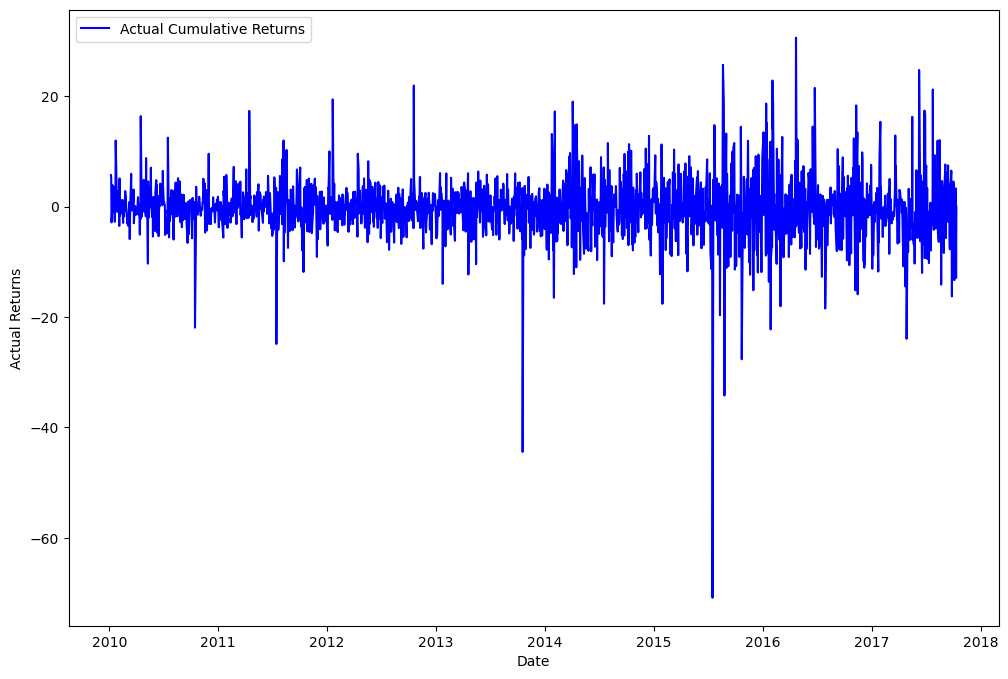

In [36]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings

warnings.filterwarnings('ignore')

class TimeSeriesModel:
    def __init__(self, ticker):
        self.ticker = ticker
        self.time_series = self.load_data()
        self.model = None

    def load_data(self):
        """
        Load stock data from Yahoo Finance.
        """
        stock_data = yf.download(self.ticker, start='2010-01-01', end=pd.Timestamp.today().strftime('%Y-%m-%d'))
        return stock_data['Close']

    def check_stationarity(self):
        """
        Perform the ADF test to check if the series is stationary.
        """
        adf_result = adfuller(self.time_series)
        print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")
        return adf_result[1] <= 0.05

    def fit_model(self):
        # Clean the data
        if self.time_series.isnull().any():
            print("Warning: Time series contains NaN values. Cleaning the data.")
            self.time_series = self.time_series.dropna()

        print("Cleaned Time Series Data:", self.time_series)

        # Check for stationarity
        if not self.check_stationarity():
            print("The time series is not stationary. Consider differencing the series.")
            self.time_series = self.time_series.diff().dropna()

        # Fit the model
        self.model = auto_arima(self.time_series, seasonal=False, trace=True,
                                error_action='ignore', suppress_warnings=True)
        
        print("Fitted ARIMA Model Summary:")
        print(self.model.summary())

    def simulate_forecast(self, num_simulations=10000, forecast_periods=10):
        """
        Simulate forecasts and return the simulation results.
        """
        if self.model is None:
            raise ValueError("Model has not been fitted yet. Please fit the model first.")

        forecast = self.model.predict(n_periods=forecast_periods)

        # Check for NaN values in the forecast
        if np.any(np.isnan(forecast)):
            print("Warning: Forecast contains NaN values. Check the model fitting and data.")
            return None, None

        forecast_index = pd.date_range(start=self.time_series.index[-1] + pd.Timedelta(days=1),
                                        periods=forecast_periods, freq='B')
        forecast_df = pd.Series(forecast, index=forecast_index)

        # Simulate noise based on the residuals
        residuals = self.model.resid()
        
        # Ensure noise_samples has the correct shape
        noise_samples = np.random.choice(residuals, size=(num_simulations, forecast_periods), replace=True)

        # Convert forecast to a NumPy array and reshape for broadcasting
        forecast_array = np.array(forecast).reshape(1, -1)  # Shape (1, forecast_periods)

        # Simulate forecast results using broadcasting
        forecast_results = forecast_array + noise_samples  # Broadcasting works here

        return forecast_results, forecast_index

    def calculate_exceedance(self, simulations, threshold_value):
        """
        Calculate the percent of simulations exceeding the threshold value.
        """
        exceedance_percent = np.mean(simulations > threshold_value, axis=0) * 100
        return exceedance_percent

    def plot_cumulative_returns(self, forecast_periods=10):
        """
        Plot the cumulative returns for the actual and predicted series, limited to the range from 2010 to 2020.
        
        :param forecast_periods: Number of forecast periods ahead.
        """
        # Filter actual returns from 2010 to 2020
        actual_returns = self.time_series.loc['2010-01-01':'2020-12-31'].pct_change().dropna()
        if actual_returns.empty:
            print("Error: No actual returns available in the specified date range.")
            return
        
        actual_cumulative_returns = (1 + actual_returns).cumprod()
        print("Actual Cumulative Returns:", actual_cumulative_returns)

        # Forecast future values using the model
        forecast = self.model.predict(n_periods=forecast_periods)
        print("Forecast from model:", forecast)

        # Check for NaN values in the forecast
        if np.any(np.isnan(forecast)):
            print("Warning: Forecast contains NaN values. Check the model fitting and data.")
            return

        forecast_index = pd.date_range(start=self.time_series.index[-1] + pd.Timedelta(days=1), periods=forecast_periods, freq='B')

        # Convert forecasted returns to actual prices
        last_actual_price = self.time_series.iloc[-1]
        forecast_prices = last_actual_price * (1 + np.array(forecast)).cumprod()
        forecast_df = pd.Series(forecast_prices, index=forecast_index)
        print("Forecasted prices series:", forecast_df)

        # Calculate predicted returns based on forecast prices
        predicted_returns = forecast_df.pct_change().dropna()
        print("Predicted Returns:", predicted_returns)

        # Calculate the last actual cumulative return
        last_actual_return = actual_cumulative_returns.iloc[-1]
        print("Last Actual Return:", last_actual_return)

        # Calculate predicted cumulative returns
        predicted_cumulative_returns = (1 + predicted_returns).cumprod()
        predicted_cumulative_returns += last_actual_return

        # Ensure the index for predicted cumulative returns is correct
        predicted_cumulative_returns.index = forecast_index[1:len(predicted_cumulative_returns) + 1]

        # Print final predicted cumulative returns for debugging
        print("Final Predicted Cumulative Returns:", predicted_cumulative_returns)

        # Convert to DataFrame for plotting if needed
        predicted_cumulative_returns_df = predicted_cumulative_returns.reset_index()
        predicted_cumulative_returns_df.columns = ['Date', 'Predicted Returns']

        # Prepare actual cumulative returns for plotting
        actual_cumulative_returns_df = actual_cumulative_returns.reset_index()
        actual_cumulative_returns_df.columns = ['Date', 'Actual Returns']

        # Plot actual vs predicted cumulative returns
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=actual_cumulative_returns_df, x='Date', y='Actual Returns', label="Actual Cumulative Returns", color="blue")
        sns.lineplot(data=predicted_cumulative_returns_df, x='Date', y='Predicted Returns', label="Predicted Cumulative Returns", color="orange")
        plt.title("Actual vs Predicted Cumulative Returns (Buy and Hold) - From 2010 to 2020")
        plt.ylabel("Cumulative Returns")
        plt.xlabel("Date")
        plt.legend()
        plt.show()

# Example usage
if __name__ == "__main__":
    ts_model = TimeSeriesModel(ticker='GOOGL')
    ts_model.fit_model()
    simulations, forecast_index = ts_model.simulate_forecast(num_simulations=10000, forecast_periods=10)
    if simulations is not None:
        percent_exceed = ts_model.calculate_exceedance(simulations, threshold_value=1500)
        print("Percent of simulations exceeding 1500 in each period:", percent_exceed)
    ts_model.plot_cumulative_returns(forecast_periods=10)